<a href="https://colab.research.google.com/github/sidharth28git/Predictive-Customer-Churn-Analysis/blob/main/Predictive_Customer_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries imported successfully!
Data loaded successfully!
--- First 5 Rows ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...    

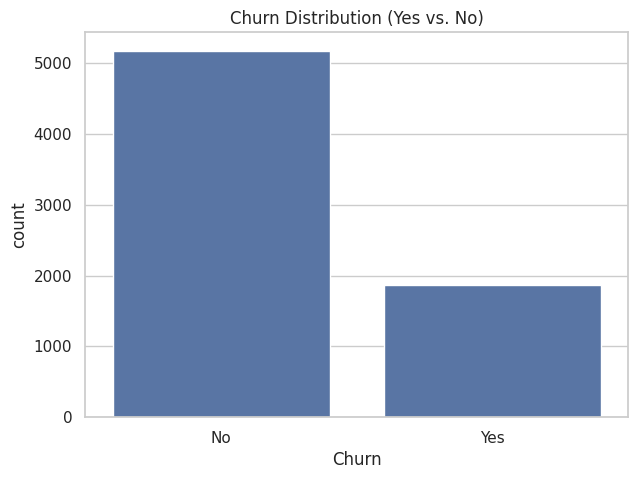

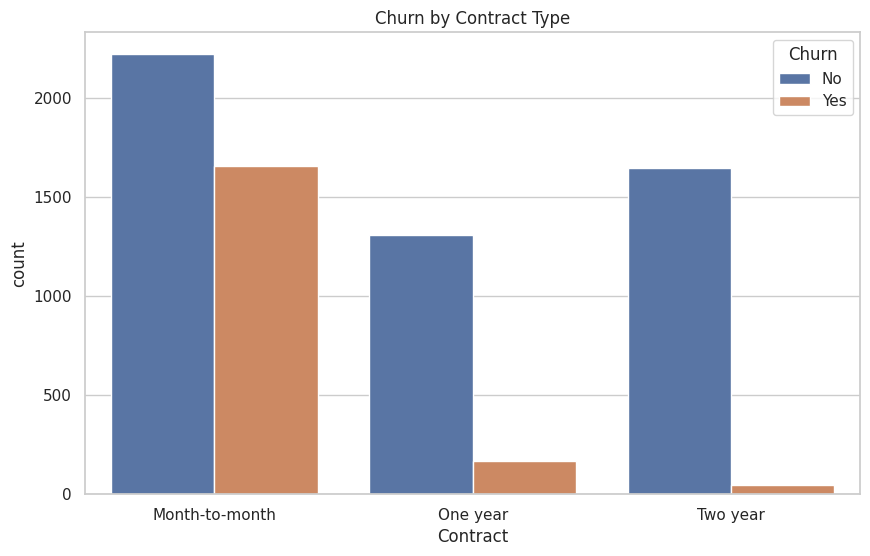

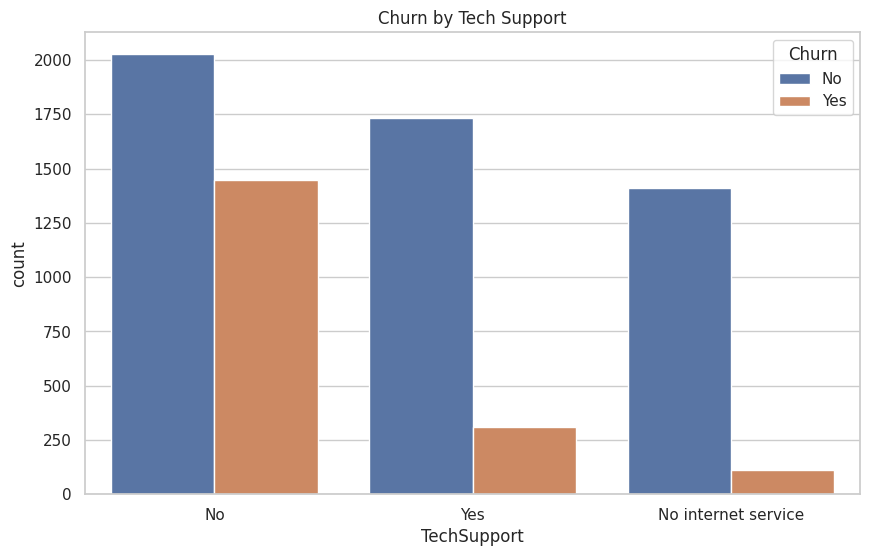

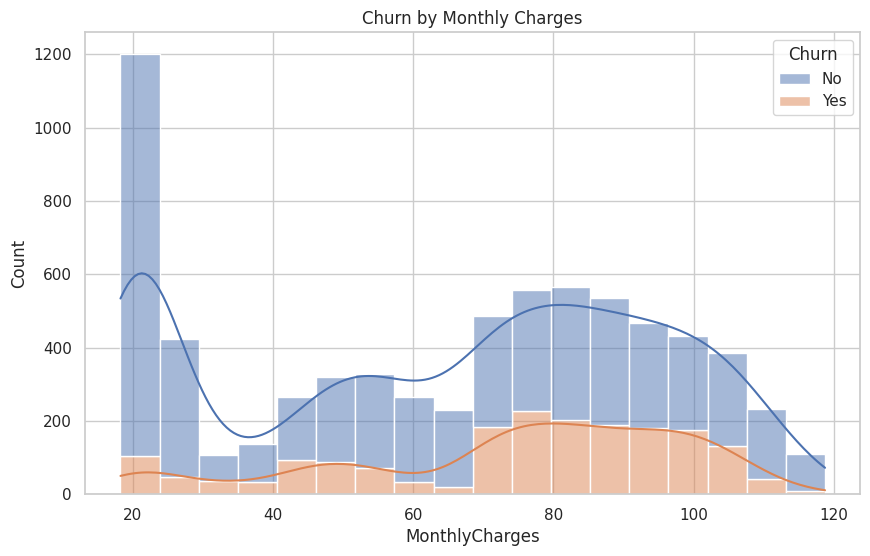

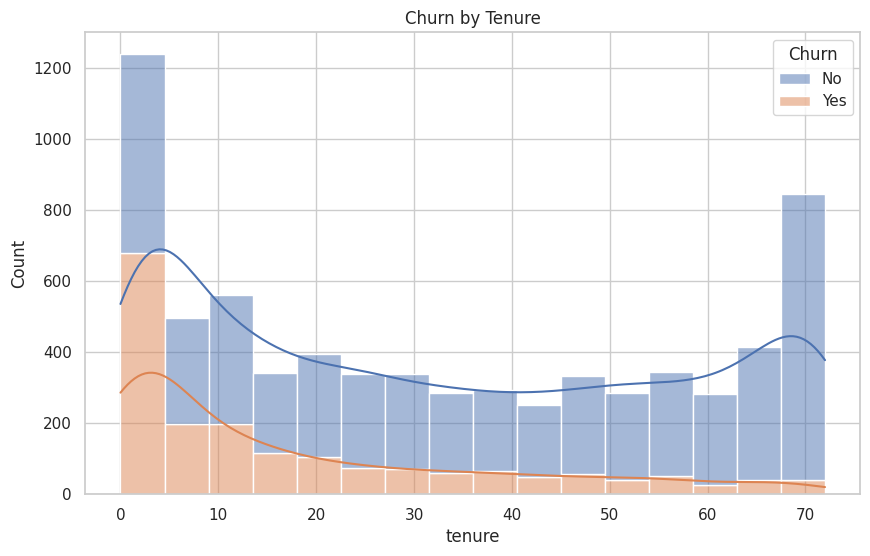


Rows with missing TotalCharges: 11
Data shape after dropping missing values: (7032, 21)

Binary columns to convert: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

Categorical columns to one-hot encode: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

--- Data Head After All Transformations ---
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  PaperlessBilling_Yes  ...  \


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:13:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Tuning finished!
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
Best accuracy during tuning (on validation sets): 80.68%

Model trained successfully!

--- Model Accuracy ---
Accuracy: 79.25%

--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1033
       Churn       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407


--- Confusion Matrix ---
[[934  99]
 [193 181]]


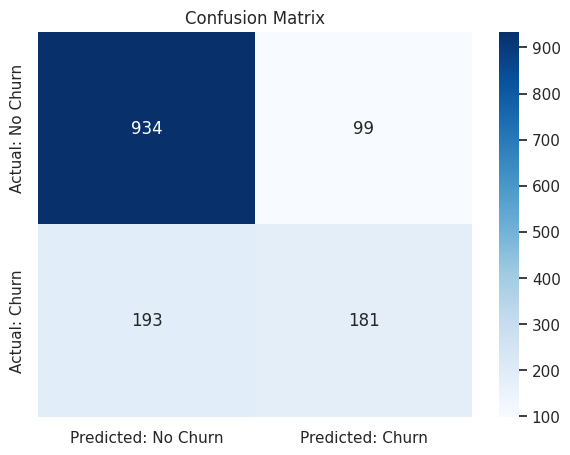


--- Key Factors Influencing Churn (XGBoost) ---
                           Feature  Importance
11     InternetService_Fiber optic    0.241071
25               Contract_One year    0.225177
26               Contract_Two year    0.144207
12              InternetService_No    0.067861
1                           tenure    0.061129
28  PaymentMethod_Electronic check    0.039090
24             StreamingMovies_Yes    0.031583
14              OnlineSecurity_Yes    0.026570
20                 TechSupport_Yes    0.020226
0                    SeniorCitizen    0.018850

--- Interpretation ---
The 'Importance' score shows how much each feature contributed to the model's predictions.
Higher values mean the feature was more important for deciding if a customer would churn.


In [ ]:
# %%
# -----------------------------------------------
# Step 0: Import Libraries
# -----------------------------------------------
# Import all the tools we need for our project.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# Add RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# --- NEW: Import XGBoost ---
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set Seaborn style for prettier charts
sns.set(style="whitegrid")
print("Libraries imported successfully!")


# %%
# -----------------------------------------------
# Step 1: Get the Data
# -----------------------------------------------
# We'll load the "Telco Customer Churn" dataset from a URL.
# This dataset is hosted by IBM.

data_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(data_url)

print("Data loaded successfully!")


# %%
# -----------------------------------------------
# Step 2: Inspect the Data (First Look)
# -----------------------------------------------
# Let's get a feel for our data.

# Show the first 5 rows
print("--- First 5 Rows ---")
print(df.head())

# Get a technical summary of all columns
# Note: 'TotalCharges' is 'object' (text), which is suspicious!
# Note: No 'Non-Null Count' is lower than 7043, except for TotalCharges (which is just an object)
# Actually, wait... all columns show 7043 non-null. Let's investigate TotalCharges.
print("\n--- Data Info ---")
df.info()

# Get descriptive statistics for numerical columns
print("\n--- Descriptive Statistics (Numerical) ---")
print(df.describe())

# Check for unique values in 'TotalCharges' that might be non-numeric
# print("\n--- Unique values in TotalCharges (sample) ---")
# print(df['TotalCharges'].unique()[0:10]) # This will often show ' ' (a space)


# %%
# -----------------------------------------------
# Step 3: Exploratory Data Analysis (EDA)
# -----------------------------------------------
# Let's visualize the data to find patterns.

# 1. How many customers churned vs. stayed?
plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution (Yes vs. No)')
plt.show()

# 2. How does Contract type affect Churn?
# This chart is very insightful! Month-to-month customers churn WAY more.
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

# 3. How does TechSupport affect Churn?
# Customers with 'No' tech support are more likely to churn.
plt.figure(figsize=(10, 6))
sns.countplot(x='TechSupport', hue='Churn', data=df)
plt.title('Churn by Tech Support')
plt.show()

# 4. How do Monthly Charges relate to Churn?
# We use a histogram, which groups numbers into bins.
# 'kde=True' adds a smooth line.
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True)
plt.title('Churn by Monthly Charges')
plt.show()

# 5. How does tenure (how long they've been a customer) relate to Churn?
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True)
plt.title('Churn by Tenure')
plt.show()


# %%
# -----------------------------------------------
# Step 4: Data Cleaning & Feature Engineering
# -----------------------------------------------
# We need to get the data ready for the model.

# --- 4a. Data Cleaning ---

# The 'TotalCharges' column is 'object' (text) because it contains empty spaces.
# Let's convert it to numbers. 'errors='coerce'' will turn any problems (like spaces) into 'NaN' (Not a Number).
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Now we find the rows that have these new 'NaN' values
print(f"\nRows with missing TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Since it's only 11 rows (a tiny fraction), the simplest solution is to drop them.
df.dropna(inplace=True)

print(f"Data shape after dropping missing values: {df.shape}")


# --- 4b. Feature Engineering (Data Transformation) ---

# The model only understands numbers. We need to convert text columns.
# We'll drop 'customerID' as it's not a predictive feature.
df = df.drop('customerID', axis=1)

# Convert binary 'Yes/No' columns to 1/0
# We find all columns that have only 2 unique values (like Yes/No, Male/Female)
# and are of type 'object' (text).
binary_cols = []
for col in df.columns:
    if df[col].dtype == 'object' and df[col].nunique() == 2:
        binary_cols.append(col)

print(f"\nBinary columns to convert: {binary_cols}")

# We'll map 'Yes' to 1 and 'No' to 0 for our target 'Churn'
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# *** FIX ***
# We must remove 'Churn' from the binary_cols list *after* we've
# manually converted it, so get_dummies doesn't process it *again*
# (which would drop the original 'Churn' column).
if 'Churn' in binary_cols:
    binary_cols.remove('Churn')
# *** END FIX ***

# For other binary columns (now NOT including 'Churn'), we use get_dummies
# 'drop_first=True' turns 'Male'/'Female' into a single 'Gender_Male' (0 or 1)
# and 'Yes'/'No' into a single 'Partner_Yes' (0 or 1)
df = pd.get_dummies(df, columns=binary_cols, drop_first=True)

# The 'if Churn_Yes' check is no longer needed as 'Churn' is correctly handled.
# if 'Churn_Yes' in df.columns:
#     df.rename(columns={'Churn_Yes': 'Churn'}, inplace=True)


# Convert multi-category columns using One-Hot Encoding
# Find all remaining 'object' columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical columns to one-hot encode: {list(categorical_cols)}")

# Use pd.get_dummies to create new columns for each category
# 'drop_first=True' avoids redundancy (e.g., if not Month-to-month or One year, it must be Two year)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\n--- Data Head After All Transformations ---")
print(df.head())
print("\n--- Data Info After All Transformations ---")
df.info() # All columns should be numerical now!


# %%
# -----------------------------------------------
# Step 5: Build the Predictive Model
# -----------------------------------------------

# --- 5a. Define Features (X) and Target (y) ---
y = df['Churn']
X = df.drop('Churn', axis=1)

# --- 5b. Split Data (Train/Test Split) ---
# We'll use 80% for training and 20% for testing.
# 'random_state=42' ensures we get the same split every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# --- 5c. Scale Numerical Data ---
# We need to scale columns like 'tenure', 'MonthlyCharges', and 'TotalCharges'
# so they are on a similar scale.

# Identify numerical columns (excluding the 0/1 dummies we just made)
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()

# Fit and transform the scaler on the TRAINING data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# ONLY transform the TEST data (using the scaler 'fit' from the training data)
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nNumerical data scaled successfully.")
print(X_train[numerical_cols].describe())


# --- 5d. Train the Model ---
# We'll use Logistic Regression, a good, simple, and interpretable model.
# model = LogisticRegression(random_state=42, max_iter=1000)

# --- NEW MODEL: Random Forest ---
# Let's try a more powerful model to improve accuracy.
# RandomForest is an "ensemble" model that builds many decision trees.
# It's great at finding complex, non-linear patterns.
# n_estimators=100 is a good default (it builds 100 trees).
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)


# --- Hyperparameter Tuning with GridSearchCV ---
# Our ~79% accuracy is a good baseline, but we can 'tune' the model's settings
# (hyperparameters) to find a better-performing combination.
# grid_search.fit(X_train, y_train)

# 4. Get the best model found by the search
# GridSearchCV automatically refits the best model on the *entire* training set
# model = grid_search.best_estimator_

# print("\nTuning finished!")
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best accuracy during tuning (on validation sets): {grid_search.best_score_ * 100:.2f}%")

# The 'model' variable is now our *best* tuned model.
# Steps 6 and 7 will use this automatically.


# --- NEW MODEL: XGBoost Classifier ---
# Let's use a very powerful model often used in competitions.
# It's a "Gradient Boosted Machine" that is excellent for tabular data.

# 1. Handle Class Imbalance
# We need to tell the model to pay more attention to the rare 'Churn' class.
# We calculate a 'scale_pos_weight'
# (count of 'No Churn') / (count of 'Churn')
# --- REMOVING for GOAL 1 ---
# value_counts = y_train.value_counts()
# scale_pos_weight = value_counts[0] / value_counts[1]
# print(f"\nCalculated 'scale_pos_weight' for XGBoost: {scale_pos_weight:.2f}")

# 2. Define the model
# use_label_encoder=False and eval_metric='logloss' are modern defaults.
# We pass our calculated weight to handle imbalance.
# model = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='logloss',
#     scale_pos_weight=scale_pos_weight,
#     random_state=42
# )

# This is the "learning" step!
# model.fit(X_train, y_train)


# --- Hyperparameter Tuning for XGBoost ---
# Let's combine XGBoost with GridSearchCV to find the *best* settings
# that balance accuracy and recall.

# 1. Define the base model (REMOVING scale_pos_weight for GOAL 1)
base_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    # scale_pos_weight=scale_pos_weight, # <-- This is now removed
    random_state=42
)

# 2. Define the 'grid' of parameters to search.
# This is a small grid to keep it fast.
param_grid = {
    'n_estimators': [100, 150],      # Number of trees
    'max_depth': [3, 5],           # Max depth (XGBoost trees are often shallow)
    'learning_rate': [0.05, 0.1]     # How fast the model learns
}

# 3. Set up the GridSearchCV
# We'll score based on 'accuracy' to get the best overall score
print("\nStarting XGBoost Hyperparameter Tuning (this may take a minute)...")
grid_search = GridSearchCV(estimator=base_model,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy') # We want the best *accuracy*

# This is the "learning" step! This will be slower.
grid_search.fit(X_train, y_train)

# 4. Get the best model found by the search
model = grid_search.best_estimator_

print("\nTuning finished!")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy during tuning (on validation sets): {grid_search.best_score_ * 100:.2f}%")


print("\nModel trained successfully!")


# %%
# -----------------------------------------------
# Step 6: Evaluate the Model
# -----------------------------------------------
# Let's see how our model did on the 'test' data it's never seen.

# Make predictions on the test set
y_pred = model.predict(X_test)

# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Model Accuracy ---")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Get the detailed Classification Report
# 'target_names' makes the report easier to read.
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Show the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Optional: Prettier Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: No Churn', 'Predicted: Churn'],
            yticklabels=['Actual: No Churn', 'Actual: Churn'])
plt.title('Confusion Matrix')
plt.show()


# %%
# -----------------------------------------------
# Step 7: Analyze Results (Find Key Factors)
# -----------------------------------------------
# This is the best part! Let's see WHAT the model learned.
# We'll look at the 'coefficients' (or weights) it assigned to each feature.

# Get the coefficients from the trained model
# coefficients = model.coef_[0] # This is for Logistic Regression

# --- NEW: Get Feature Importances from Random Forest ---
# Random Forest calculates importance differently, by measuring how much
# each feature contributes to making good predictions across all the trees.
importances = model.feature_importances_

# Create a DataFrame to hold the feature names and their coefficients
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by the *absolute value* of the coefficient to see the most impactful features
# feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
# feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

# It's often more useful to sort by the actual value to see "pro-churn" and "anti-churn"
# Sort by Importance, descending.
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\n--- Key Factors Influencing Churn (XGBoost) ---")
print(feature_importance.head(10)) # Print top 10 features

print("\n--- Interpretation ---")
# print("Large POSITIVE coefficients (top) are the biggest drivers OF CHURN.")
# print("Large NEGATIVE coefficients (bottom) are the biggest drivers of RETENTION (staying).")
print("The 'Importance' score shows how much each feature contributed to the model's predictions.")
print("Higher values mean the feature was more important for deciding if a customer would churn.")





